# Imbalanced Dataset Performance (UNSW-NB15)

In [1]:
# Data Handling & Preprocessing
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Training
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualization & Debugging
import matplotlib.pyplot as plt
import seaborn as sns

## Data Collection
The dataset I'm using is UNSW-NB15, the data already split so I don't need to split it manually. The dataset is divided into:
- Training-set with CSV format.
- Testing-set with CSV format.

Load the Dataset

In [2]:
# Load CSV files
df_train = pd.read_csv('UNSW_NB15_training-set.csv')
df_test = pd.read_csv('UNSW_NB15_testing-set.csv')

# Display the first 5 rows
df_train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


Check class distribution and answer this question:
- What are the minority attack classes?
- How severe is the imbalance?

In [3]:
# Check column names
print(df_train.columns)
print("-----------------------------------")

# Count occurences of each unieque value in the attack_cat column
print(df_train["attack_cat"].value_counts())
print("-----------------------------------")
print(df_test["attack_cat"].value_counts())

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')
-----------------------------------
attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64
-----------------------------------
attack_cat
Normal            37000
Generic           188

## Data Preprocessing

**Clean the data:** Handle missing values, remove duplicates, and correct inconsistencies.

In [4]:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [5]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


In [6]:
# Drop rows where 'attack_cat' is 'Normal'
df_train_attack = df_train[df_train['attack_cat'] != 'Normal']
df_test_attack = df_test[df_test['attack_cat'] != 'Normal']

# Count occurences of each attack classes
print(df_train_attack["attack_cat"].value_counts())
print("-----------------------------------")

print(df_test_attack["attack_cat"].value_counts())

attack_cat
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64
-----------------------------------
attack_cat
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: count, dtype: int64


**Feature Encoding:** Convert categorical variables into numerical form using **Label Encoding**.

In [7]:
encoder = LabelEncoder()
df_train_attack['proto'] = encoder.fit_transform(df_train_attack['proto'])
df_train_attack['service'] = encoder.fit_transform(df_train_attack['service'])
df_train_attack['state'] = encoder.fit_transform(df_train_attack['state'])

df_test_attack['proto'] = encoder.fit_transform(df_test_attack['proto'])
df_test_attack['service'] = encoder.fit_transform(df_test_attack['service'])
df_test_attack['state'] = encoder.fit_transform(df_test_attack['state'])

C:\Users\Acer\AppData\Local\Temp\ipykernel_5164\20991864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_attack['proto'] = encoder.fit_transform(df_train_attack['proto'])
C:\Users\Acer\AppData\Local\Temp\ipykernel_5164\20991864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_attack['service'] = encoder.fit_transform(df_train_attack['service'])
C:\Users\Acer\AppData\Local\Temp\ipykernel_5164\20991864.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [8]:
y = df_train_attack['attack_cat']  # Multiclass target (9 attack types)
y = encoder.fit_transform(y)  # Convert attack categories to numbers
X = df_train_attack.drop(columns=['id', 'attack_cat', 'label'])  # Remove unnecessary columns

y_test = df_test_attack['attack_cat']  # Multiclass target (9 attack types)
y_test = encoder.fit_transform(y_test)  # Convert attack categories to numbers
X_test = df_test_attack.drop(columns=['id', 'attack_cat', 'label'])  # Remove unnecessary columns

**Normalization/Scaling:** Use MinMaxScaler for better model performance.

In [9]:
# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_test_normalized = scaler.transform(X_test)

# Convert back to DataFrame for better readability (optional)
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns)

In [10]:
# Display the first 5 rows of the normalized data
X_normalized.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,1.500024e-07,0.148438,0.0,0.5,0.000104,0.0,0.000011,0.0,0.111111,0.996078,...,0.00,0.00,0.000000,0.046875,0.0,0.0,0.0,0.016949,0.058824,0.0
1,1.500024e-07,0.390625,0.0,0.5,0.000104,0.0,0.000011,0.0,0.111111,0.996078,...,0.02,0.02,0.033333,0.093750,0.0,0.0,0.0,0.016949,0.117647,0.0
2,1.500024e-07,0.085938,0.0,0.5,0.000104,0.0,0.000011,0.0,0.111111,0.996078,...,0.00,0.00,0.000000,0.078125,0.0,0.0,0.0,0.000000,0.098039,0.0
3,5.000080e-08,0.968750,0.0,0.5,0.000104,0.0,0.000011,0.0,0.333333,0.996078,...,0.02,0.02,0.033333,0.093750,0.0,0.0,0.0,0.016949,0.098039,0.0
4,1.333355e-07,0.656250,0.0,0.5,0.000104,0.0,0.000011,0.0,0.125000,0.996078,...,0.00,0.00,0.000000,0.046875,0.0,0.0,0.0,0.169492,0.058824,0.0


In [11]:
# Display the first 5 rows of the normalized data for test set
X_test_normalized.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,1.536669e-02,0.585938,0.0,1.0,0.001976,0.0,0.000094,0.0,0.000021,0.996078,...,0.00,0.0,0.0,0.015625,0.0,0.0,0.0,0.0,0.0,0.0
1,1.536669e-02,0.585938,0.0,1.0,0.001976,0.0,0.000094,0.0,0.000021,0.996078,...,0.00,0.0,0.0,0.015625,0.0,0.0,0.0,0.0,0.0,0.0
2,1.536669e-02,0.585938,0.0,1.0,0.001976,0.0,0.000094,0.0,0.000021,0.996078,...,0.00,0.0,0.0,0.015625,0.0,0.0,0.0,0.0,0.0,0.0
3,1.536669e-02,0.585938,0.0,1.0,0.001976,0.0,0.000094,0.0,0.000021,0.996078,...,0.00,0.0,0.0,0.015625,0.0,0.0,0.0,0.0,0.0,0.0
4,1.500024e-07,0.726562,0.0,1.0,0.000104,0.0,0.000003,0.0,0.111111,0.996078,...,0.02,0.0,0.0,0.015625,0.0,0.0,0.0,0.0,0.0,0.0


**Feature Selection:** Choose relevant features.


In [12]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=26)  # Select top 15 features
fit = rfe.fit(X_normalized, y)

# Selected features
selected_features = X.columns[fit.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sttl', 'dttl',
       'sload', 'sloss', 'sinpkt', 'sjit', 'djit', 'synack', 'smean', 'dmean',
       'ct_srv_src', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst'],
      dtype='object')


## Exploratory Data Analysis (EDA)

Visualize the Class Imbalance

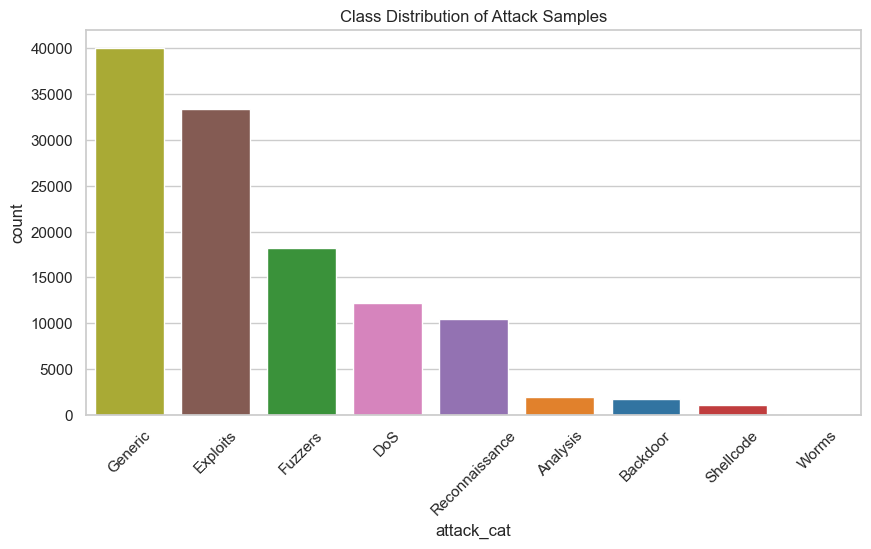

In [13]:
plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")
sns.countplot(data=df_train_attack, 
              x="attack_cat", 
              order=df_train_attack['attack_cat'].value_counts().index, 
              hue="attack_cat", 
              palette="tab10", 
              legend=False)
plt.xticks(rotation=45)
plt.title('Class Distribution of Attack Samples')
plt.show()

To measure how severe the imbalance is, I'm use imbalance ratio (IR) and other statistical metrics.
The imbalance ratio (IR) tells us how imbalanced the dataset is. It’s calculated as:

IR = Majority class count / Minority class count

- If IR > 1.5, the dataset is imbalanced.  
- If IR > 10, the imbalance is severe.  
- If any class has less than 5% of the dataset, which indicates a significant imbalance.

In [14]:
# Find the majority and minority class sizes
class_counts = df_train_attack['attack_cat'].value_counts()
majority_class = class_counts.max()
minority_class = class_counts.min()

# Compute imbalance ratio
imbalance_ratio = majority_class / minority_class
print(f"Imbalance Ratio (IR): {imbalance_ratio:.2f}\n")

# Compute percentage distribution
total_samples = len(df_train_attack)
percentages = (class_counts / total_samples) * 100
print(percentages)

Imbalance Ratio (IR): 307.69

attack_cat
Generic           33.517400
Exploits          27.981163
Fuzzers           15.237010
DoS               10.276435
Reconnaissance     8.790776
Analysis           1.675870
Backdoor           1.463034
Shellcode          0.949380
Worms              0.108932
Name: count, dtype: float64


The answer above question is:
- There is few minority attack classes **less then 5%** of the dataset here: Worms, Shellcode, Backdoor, and Analysis.
- The Imbalance Ratio is 307.69 which indicate the dataset is **highly imbalance!**.

## Data Splitting

In [15]:
X_normalized = X_normalized[selected_features]
X_test_normalized = X_test_normalized[selected_features] 

# Split into train (70%) and validation (30%) sets
X_train, X_val, y_train, y_val = train_test_split(X_normalized, y, test_size=0.3, random_state=42, stratify=y)

print("Data preparation complete!")
print(f"Training set: {X_train.shape}\nValidation set: {X_val.shape}\nTesting set: {X_test_normalized.shape}")

Data preparation complete!
Training set: (83538, 26)
Validation set: (35803, 26)
Testing set: (45332, 26)


## **Train Machine Learning Models**
- Choose models for evaluation:
  - **XGBoost**
  - **Random Forest** (Baseline)
  - **Neural Networks (MLPClassifier)**
- Train each model using the **imbalanced dataset**.

In [ ]:
# Train the XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = xgb_model.predict(X_val)

# Evaluate the XGBoost model
accuracy = accuracy_score(y_val, y_val_pred)
print(f'XGBoost Validation Accuracy: {accuracy:.2f}')
print(f'\nXGBoost Classification Report:\n', classification_report(y_val, y_val_pred, target_names=encoder.classes_))
print('\nXGBoost Confusion Matrix:\n', confusion_matrix(y_val, y_val_pred))

XGBoost Validation Accuracy: 0.81

XGBoost Classification Report:
                 precision    recall  f1-score   support

      Analysis       0.78      0.23      0.36       600
      Backdoor       0.76      0.12      0.21       524
           DoS       0.39      0.12      0.19      3679
      Exploits       0.63      0.92      0.75     10018
       Fuzzers       0.96      0.89      0.93      5455
       Generic       1.00      0.98      0.99     12000
Reconnaissance       0.92      0.75      0.83      3148
     Shellcode       0.67      0.74      0.70       340
         Worms       0.65      0.33      0.44        39

      accuracy                           0.81     35803
     macro avg       0.75      0.57      0.60     35803
  weighted avg       0.81      0.81      0.79     35803


XGBoost Confusion Matrix:
 [[  141    11    51   395     2     0     0     0     0]
 [   10    65    45   392     2     0     5     5     0]
 [    2     1   456  3150    22     7    11    30     0]
 [ 

In [ ]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_val, y_val_pred_rf)
print(f'Random Forest Validation Accuracy: {rf_accuracy:.2f}')
print(f'\nRandom Forest Classification Report:\n', classification_report(y_val, y_val_pred_rf, target_names=encoder.classes_))
print('\nRandom Forest Confusion Matrix:\n', confusion_matrix(y_val, y_val_pred_rf))

Random Forest Validation Accuracy: 0.81

Random Forest Classification Report:
                 precision    recall  f1-score   support

      Analysis       0.78      0.22      0.34       600
      Backdoor       0.70      0.13      0.22       524
           DoS       0.31      0.23      0.26      3679
      Exploits       0.64      0.83      0.73     10018
       Fuzzers       0.95      0.89      0.92      5455
       Generic       1.00      0.98      0.99     12000
Reconnaissance       0.92      0.74      0.82      3148
     Shellcode       0.68      0.67      0.68       340
         Worms       0.64      0.18      0.28        39

      accuracy                           0.80     35803
     macro avg       0.73      0.54      0.58     35803
  weighted avg       0.80      0.80      0.79     35803


Random Forest Confusion Matrix:
 [[  131    18   114   332     5     0     0     0     0]
 [   12    69   127   294    11     0     5     6     0]
 [    1     1   851  2734    33     9    2

In [ ]:
# Train the MLPClassifier model
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred_mlp = mlp_model.predict(X_val)

# Evaluate the MLPClassifier model
mlp_accuracy = accuracy_score(y_val, y_val_pred_mlp)
print(f'MLPClassifier Validation Accuracy: {mlp_accuracy:.2f}')
print(f'\nMLPClassifier Classification Report:\n', classification_report(y_val, y_val_pred_mlp, target_names=encoder.classes_))
print('\nMLPClassifier Confusion Matrix:\n', confusion_matrix(y_val, y_val_pred_mlp))

MLPClassifier Validation Accuracy: 0.81

MLPClassifier Classification Report:
                 precision    recall  f1-score   support

      Analysis       0.74      0.20      0.31       600
      Backdoor       0.57      0.03      0.06       524
           DoS       0.42      0.07      0.12      3679
      Exploits       0.62      0.93      0.74     10018
       Fuzzers       0.92      0.87      0.89      5455
       Generic       1.00      0.98      0.99     12000
Reconnaissance       0.88      0.74      0.80      3148
     Shellcode       0.59      0.56      0.58       340
         Worms       0.86      0.15      0.26        39

      accuracy                           0.80     35803
     macro avg       0.73      0.50      0.53     35803
  weighted avg       0.79      0.80      0.77     35803


MLPClassifier Confusion Matrix:
 [[  119     6    19   456     0     0     0     0     0]
 [    0    17    23   457    15     0     8     4     0]
 [    3     2   247  3300    60     6    2

## **Evaluate Model Performance**
- Use the **testing set** to evaluate trained models.
- Compute performance metrics:
  - **Accuracy**
  - **Precision, Recall, F1-score**
  - **Confusion Matrix**
- Compare results to assess improvement.

In [ ]:
# Prediction on testing set
y_test_pred_xgb = xgb_model.predict(X_test_normalized)

# Evaluate the XGBoost model on testing set
xbg_accuracy_test = accuracy_score(y_test, y_test_pred_xgb)
print(f'XGBoost On Testing Set Accuracy: {xbg_accuracy_test:.2f}')
print(f'\nXGBoost On Testing Set Classification Report:\n', classification_report(y_test, y_test_pred_xgb, target_names=encoder.classes_))
print('\nXGBoost On Testing Set Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred_xgb))

In [ ]:
# Prediction on testing set
y_test_pred_rf = rf_model.predict(X_test_normalized)

# Evaluate the Random Forest model on testing set
rf_accuracy_test = accuracy_score(y_test, y_test_pred_rf)
print(f'Random Forest On Testing Set Accuracy: {rf_accuracy_test:.2f}')
print(f'\nRandom Forest On Testing Set Classification Report:\n', classification_report(y_test, y_test_pred_rf, target_names=encoder.classes_))
print('\nRandom Forest On Testing Set Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred_rf))

In [ ]:
# Prediction on testing set
y_test_pred_mlp = mlp_model.predict(X_test_normalized)

# Evaluate the MLPClassifier model on testing set
mlp_accuracy_test = accuracy_score(y_test, y_test_pred_mlp)
print(f'MLPClassifier On Testing Set Accuracy: {mlp_accuracy_test:.2f}')
print(f'\nMLPClassifier On Testing Set Classification Report:\n', classification_report(y_test, y_test_pred_mlp, target_names=encoder.classes_))
print('\nMLPClassifier On Testing Set Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred_mlp))

## **Step 4: Model Validation**
- Perform **Cross-validation** on the training set.
- Conduct **Hyperparameter tuning** (GridSearchCV, RandomizedSearchCV).
- Check for **overfitting/underfitting**.

## **Step 5: Conclusion**
- Summarize model performances.
- Identify the best-performing model for **network intrusion detection**.
- Discuss whether **balancing improved model performance**.